In [ ]:
!wget https://github.com/hfg-gmuend/openmoji/releases/latest/download/openmoji-72x72-color.zip
!mkdir emojis
!unzip -q openmoji-72x72-color.zip -d ./emojis

In [ ]:
pip install tensorflow==2.3.0

In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.3.0


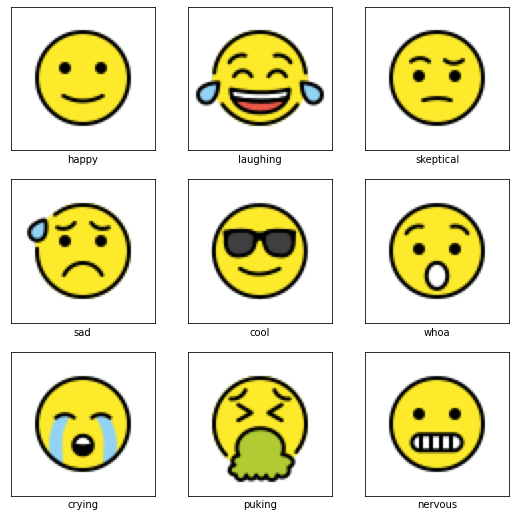

In [ ]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
for class_id, values in emojis.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [ ]:
def create_example():
    class_id = np.random.randint(0, 9)
    image = np.ones((144, 144, 3)) * 255
    row = np.random.randint(0, 72)
    col = np.random.randint(0, 72)
    image[row: row + 72, col: col + 72, :] = np.array(emojis[class_id]['image'])
    return image.astype('uint8'), class_id, (row + 10) / 144, (col + 10) / 144

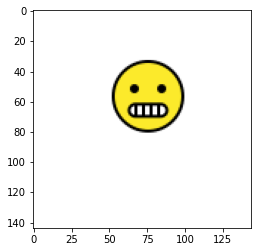

In [ ]:
image, class_id, row, col = create_example()
plt.imshow(image);

In [ ]:
row * 144, col * 144

(31.0, 50.0)

In [ ]:
def plot_bounding_box(image, gt_coords, pred_coords = [], norm = False):
    if norm:
        image *= 255
        image = image.astype('uint8')
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)

    row, col = gt_coords
    row *= 144
    col *= 144
    draw.rectangle((col, row, col + 52, row + 52), outline = 'green', width = 3)

    if len(pred_coords) == 2:
        row, col = pred_coords
        row *= 144
        col *= 144
        draw.rectangle((col, row, col + 52, row + 52), outline = 'red', width = 3)
    return image

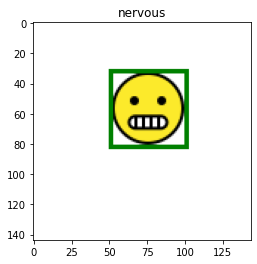

In [ ]:
image = plot_bounding_box(image, gt_coords=[row, col])
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

In [ ]:
def data_generator(batch_size = 16):
    while True:
        x_batch = np.zeros((batch_size, 144, 144, 3))
        y_batch = np.zeros((batch_size, 9))
        bbox_batch = np.zeros((batch_size, 2))

        for i in range(batch_size):
            image, class_id, row, col = create_example()
            x_batch[i] = image / 255.
            y_batch[i, class_id] = 1.0
            bbox_batch[i] = np.array([row, col])
        yield {'image' : x_batch}, {'class_out':y_batch, 'box_out': bbox_batch}

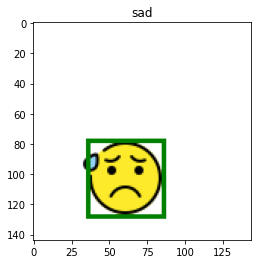

In [ ]:
example, label = next(data_generator(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_bounding_box(image, coords, norm = True)
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

In [ ]:
input_ = Input(shape = (144, 144, 3), name = 'image')

x = input_

for i in range(5):
    n_filters = 2**(4 + i)
    x = Conv2D(n_filters, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

class_out = Dense(9, activation='softmax', name = 'class_out')(x)
box_out = Dense(2, name = 'box_out')(x)

model = tf.keras.models.Model(input_, [class_out, box_out])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 144, 144, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 142, 142, 16) 448         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 142, 142, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 71, 71, 16)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(IoU, self).__init__(**kwargs)

        self.iou = self.add_weight(name = 'iou', initializer = 'zeros')
        self.total_iou = self.add_weight(name = 'total_iou', initializer = 'zeros')
        self.num_ex = self.add_weight(name = 'num_ex', initializer = 'zeros')

    def update_state(self, y_true, y_pred, sample_weight = None):
        def get_box(y):
            rows, cols = y[:, 0], y[:, 1]
            rows, cols = rows * 144, cols * 144
            y1, y2 = rows, rows + 52
            x1, x2 = cols, cols + 52
            return x1, y1, x2, y2
        
        def get_area(x1, y1, x2, y2):
            return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)

        gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
        p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)

        i_x1 = tf.maximum(gt_x1, p_x1)
        i_y1 = tf.maximum(gt_y1, p_y1)
        i_x2 = tf.minimum(gt_x2, p_x2)
        i_y2 = tf.minimum(gt_y2, p_y2)

        i_area = get_area(i_x1, i_y1, i_x2, i_y2)
        u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area

        iou = tf.math.divide(i_area, u_area)
        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))
        self.iou = tf.math.divide(self.total_iou, self.num_ex)

    def result(self):
        return self.iou

    def reset_state(self):
        self.iou = self.add_weight(name = 'iou', initializer = 'zeros')
        self.total_iou = self.add_weight(name = 'total_iou', initializer = 'zeros')
        self.num_ex = self.add_weight(name = 'num_ex', initializer = 'zeros')

In [ ]:
model.compile(
    loss = {
        'class_out' : 'categorical_crossentropy',
        'box_out': 'mse'
    },
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), 
    metrics = {
        'class_out' : 'accuracy',
        'box_out': IoU(name = 'iou')
    }
)

In [ ]:
def test_model(model, test_datagen):
    example, label = next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['box_out']

    pred_y, pred_box = model.predict(x)

    pred_coords = pred_box[0]
    gt_coords = box[0]
    pred_class = np.argmax(pred_y[0])
    image = x[0]

    gt = emojis[np.argmax(y[0])]['name']
    pred_class_name = emojis[pred_class]['name']

    image = plot_bounding_box(image, gt_coords, pred_coords, norm = True)
    color = 'green' if gt == pred_class_name else 'red'

    plt.imshow(image)
    plt.xlabel(f'Pred: {pred_class_name}', color = color)
    plt.ylabel(f'GT: {gt}', color = color)
    plt.xticks([])
    plt.yticks([])

In [ ]:
def test(model):
    test_datagen = data_generator(1)
    
    plt.figure(figsize=(16, 4))

    for i in range(0, 6):
        plt.subplot(1, 6, i + 1)
        test_model(model, test_datagen)
    plt.show()

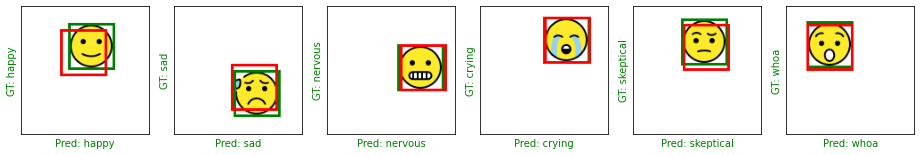

In [ ]:
test(model)

In [ ]:
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        test(self.model)

Epoch 1/50
499/500 [============================>.] - ETA: 0s - loss: 1.1726 - class_out_loss: 0.8065 - box_out_loss: 0.3661 - class_out_accuracy: 0.7188 - box_out_iou: -0.0201

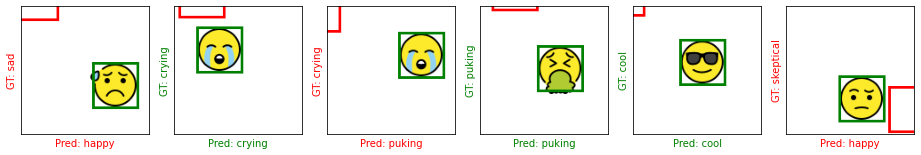

500/500 [==============================] - 12s 25ms/step - loss: 1.1704 - class_out_loss: 0.8050 - box_out_loss: 0.3654 - class_out_accuracy: 0.7194 - box_out_iou: -0.0196
Epoch 2/50
500/500 [==============================] - ETA: 0s - loss: 0.0619 - class_out_loss: 0.0164 - box_out_loss: 0.0455 - class_out_accuracy: 0.9990 - box_out_iou: 0.2580

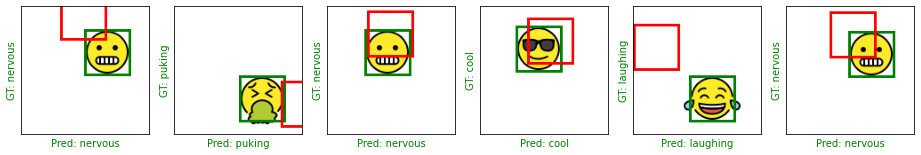

500/500 [==============================] - 12s 25ms/step - loss: 0.0619 - class_out_loss: 0.0164 - box_out_loss: 0.0455 - class_out_accuracy: 0.9990 - box_out_iou: 0.2580
Epoch 3/50
499/500 [============================>.] - ETA: 0s - loss: 0.0236 - class_out_loss: 0.0038 - box_out_loss: 0.0197 - class_out_accuracy: 1.0000 - box_out_iou: 0.3623

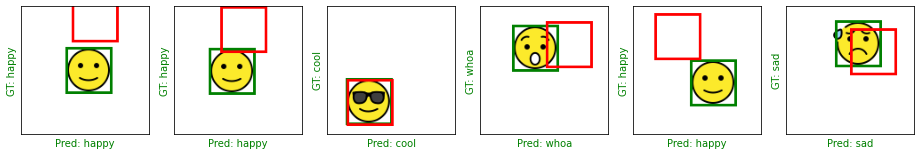

500/500 [==============================] - 13s 25ms/step - loss: 0.0235 - class_out_loss: 0.0038 - box_out_loss: 0.0197 - class_out_accuracy: 1.0000 - box_out_iou: 0.3625
Epoch 4/50
500/500 [==============================] - ETA: 0s - loss: 0.0177 - class_out_loss: 0.0045 - box_out_loss: 0.0131 - class_out_accuracy: 0.9991 - box_out_iou: 0.4311

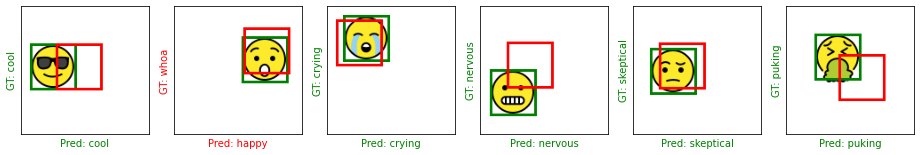

500/500 [==============================] - 13s 25ms/step - loss: 0.0177 - class_out_loss: 0.0045 - box_out_loss: 0.0131 - class_out_accuracy: 0.9991 - box_out_iou: 0.4311
Epoch 5/50
500/500 [==============================] - ETA: 0s - loss: 0.0059 - class_out_loss: 0.0014 - box_out_loss: 0.0045 - class_out_accuracy: 1.0000 - box_out_iou: 0.5946

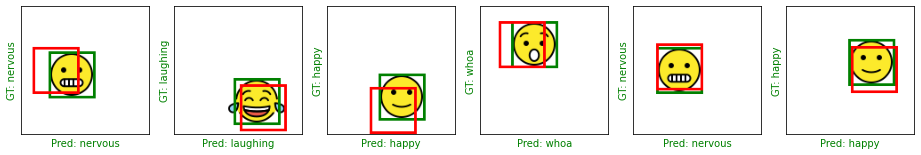

500/500 [==============================] - 13s 26ms/step - loss: 0.0059 - class_out_loss: 0.0014 - box_out_loss: 0.0045 - class_out_accuracy: 1.0000 - box_out_iou: 0.5946
Epoch 6/50
499/500 [============================>.] - ETA: 0s - loss: 0.0046 - class_out_loss: 0.0010 - box_out_loss: 0.0036 - class_out_accuracy: 1.0000 - box_out_iou: 0.6229

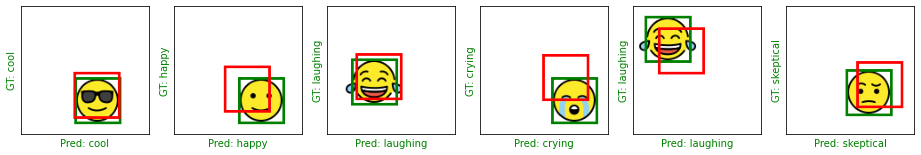

500/500 [==============================] - 13s 26ms/step - loss: 0.0046 - class_out_loss: 0.0010 - box_out_loss: 0.0036 - class_out_accuracy: 1.0000 - box_out_iou: 0.6230
Epoch 7/50
500/500 [==============================] - ETA: 0s - loss: 0.0041 - class_out_loss: 7.9714e-04 - box_out_loss: 0.0033 - class_out_accuracy: 1.0000 - box_out_iou: 0.6351

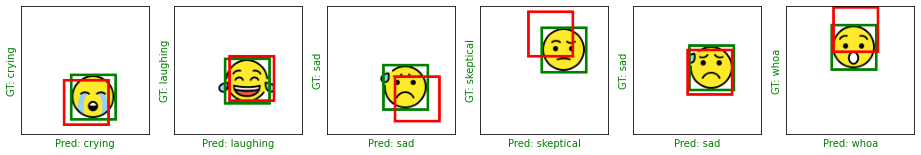

500/500 [==============================] - 13s 27ms/step - loss: 0.0041 - class_out_loss: 7.9714e-04 - box_out_loss: 0.0033 - class_out_accuracy: 1.0000 - box_out_iou: 0.6351
Epoch 8/50
499/500 [============================>.] - ETA: 0s - loss: 0.0040 - class_out_loss: 7.2184e-04 - box_out_loss: 0.0033 - class_out_accuracy: 1.0000 - box_out_iou: 0.6345

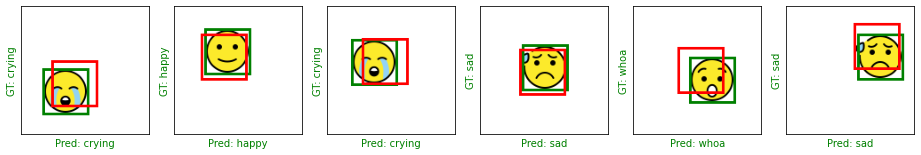

500/500 [==============================] - 13s 26ms/step - loss: 0.0040 - class_out_loss: 7.2095e-04 - box_out_loss: 0.0033 - class_out_accuracy: 1.0000 - box_out_iou: 0.6345
Epoch 9/50
499/500 [============================>.] - ETA: 0s - loss: 0.0037 - class_out_loss: 5.8280e-04 - box_out_loss: 0.0031 - class_out_accuracy: 1.0000 - box_out_iou: 0.6442

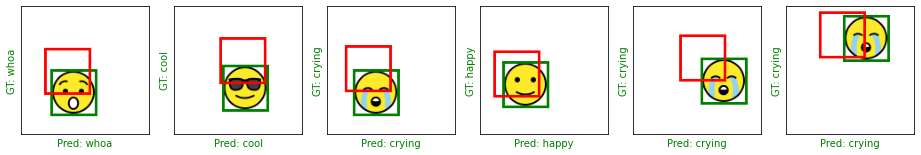

500/500 [==============================] - 13s 27ms/step - loss: 0.0037 - class_out_loss: 5.8333e-04 - box_out_loss: 0.0031 - class_out_accuracy: 1.0000 - box_out_iou: 0.6442
Epoch 10/50
499/500 [============================>.] - ETA: 0s - loss: 0.0027 - class_out_loss: 5.3578e-04 - box_out_loss: 0.0021 - class_out_accuracy: 1.0000 - box_out_iou: 0.6918

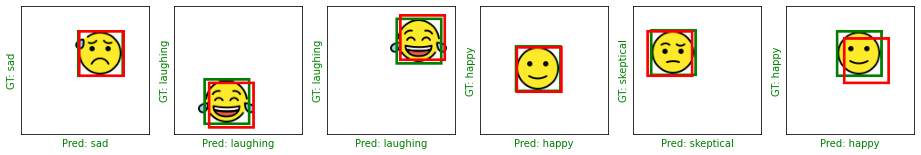

500/500 [==============================] - 13s 27ms/step - loss: 0.0027 - class_out_loss: 5.3705e-04 - box_out_loss: 0.0021 - class_out_accuracy: 1.0000 - box_out_iou: 0.6918
Epoch 11/50
500/500 [==============================] - ETA: 0s - loss: 0.0027 - class_out_loss: 5.8398e-04 - box_out_loss: 0.0021 - class_out_accuracy: 1.0000 - box_out_iou: 0.6936

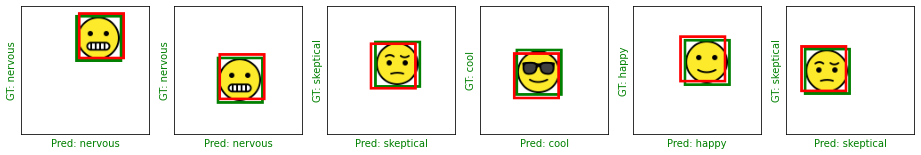

500/500 [==============================] - 14s 27ms/step - loss: 0.0027 - class_out_loss: 5.8398e-04 - box_out_loss: 0.0021 - class_out_accuracy: 1.0000 - box_out_iou: 0.6936
Epoch 12/50
499/500 [============================>.] - ETA: 0s - loss: 0.0024 - class_out_loss: 4.3206e-04 - box_out_loss: 0.0019 - class_out_accuracy: 1.0000 - box_out_iou: 0.7009

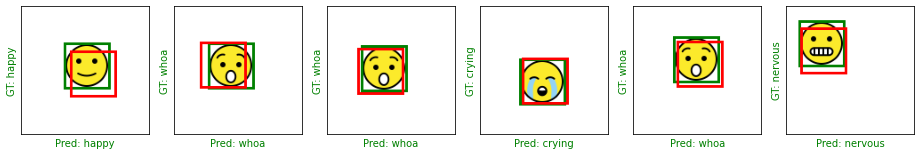

500/500 [==============================] - 14s 28ms/step - loss: 0.0024 - class_out_loss: 4.3162e-04 - box_out_loss: 0.0019 - class_out_accuracy: 1.0000 - box_out_iou: 0.7010
Epoch 13/50
500/500 [==============================] - ETA: 0s - loss: 0.0023 - class_out_loss: 3.9624e-04 - box_out_loss: 0.0019 - class_out_accuracy: 1.0000 - box_out_iou: 0.7060

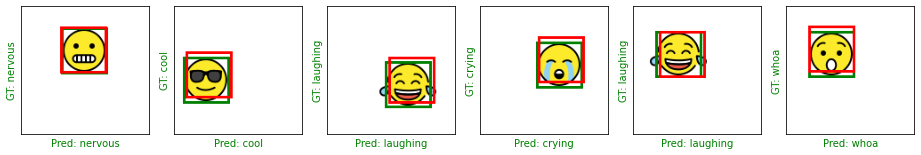

500/500 [==============================] - 14s 29ms/step - loss: 0.0023 - class_out_loss: 3.9624e-04 - box_out_loss: 0.0019 - class_out_accuracy: 1.0000 - box_out_iou: 0.7060
Epoch 14/50
500/500 [==============================] - ETA: 0s - loss: 0.0022 - class_out_loss: 4.2233e-04 - box_out_loss: 0.0018 - class_out_accuracy: 1.0000 - box_out_iou: 0.7106

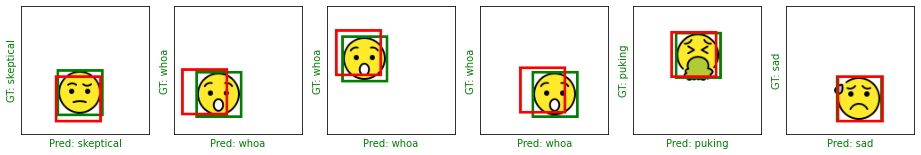

500/500 [==============================] - 15s 29ms/step - loss: 0.0022 - class_out_loss: 4.2233e-04 - box_out_loss: 0.0018 - class_out_accuracy: 1.0000 - box_out_iou: 0.7106
Epoch 15/50
499/500 [============================>.] - ETA: 0s - loss: 0.0020 - class_out_loss: 3.9752e-04 - box_out_loss: 0.0016 - class_out_accuracy: 1.0000 - box_out_iou: 0.7247

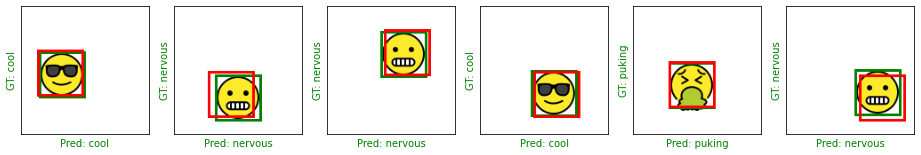

500/500 [==============================] - 15s 30ms/step - loss: 0.0020 - class_out_loss: 3.9720e-04 - box_out_loss: 0.0016 - class_out_accuracy: 1.0000 - box_out_iou: 0.7246
Epoch 16/50
500/500 [==============================] - ETA: 0s - loss: 0.0019 - class_out_loss: 3.7244e-04 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.7285

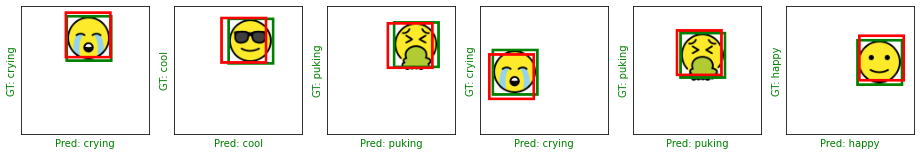

500/500 [==============================] - 15s 30ms/step - loss: 0.0019 - class_out_loss: 3.7244e-04 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.7285
Epoch 17/50
499/500 [============================>.] - ETA: 0s - loss: 0.0019 - class_out_loss: 3.8690e-04 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.7286

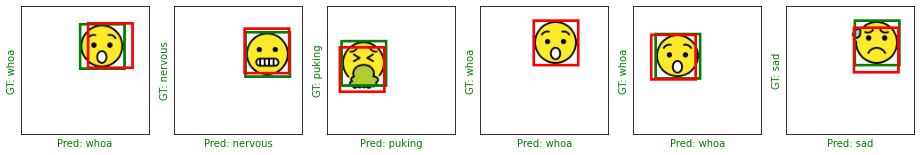

500/500 [==============================] - 15s 30ms/step - loss: 0.0019 - class_out_loss: 3.8632e-04 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.7285
Epoch 18/50
500/500 [==============================] - ETA: 0s - loss: 0.0018 - class_out_loss: 3.6970e-04 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.7331

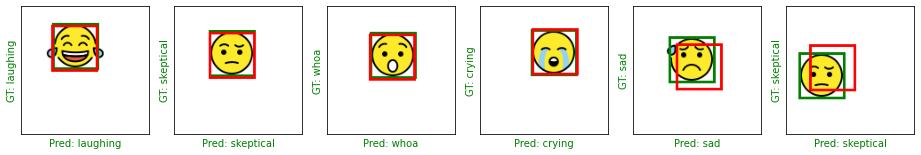

500/500 [==============================] - 15s 30ms/step - loss: 0.0018 - class_out_loss: 3.6970e-04 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.7331
Epoch 19/50
499/500 [============================>.] - ETA: 0s - loss: 0.0018 - class_out_loss: 3.4189e-04 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.7329

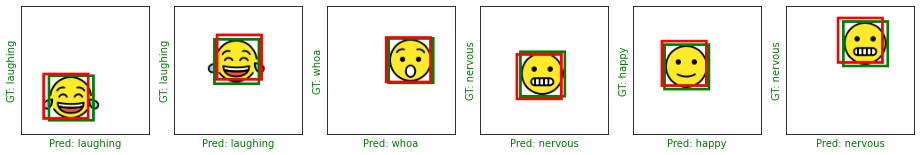

500/500 [==============================] - 15s 30ms/step - loss: 0.0018 - class_out_loss: 3.4210e-04 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.7329
Epoch 20/50
499/500 [============================>.] - ETA: 0s - loss: 0.0017 - class_out_loss: 3.1778e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.7397

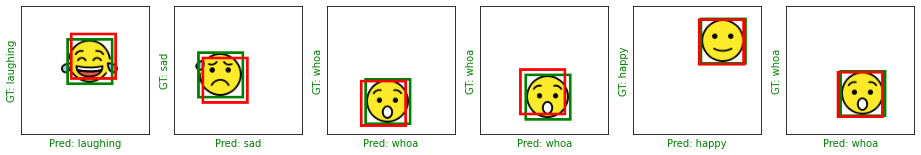

500/500 [==============================] - 15s 30ms/step - loss: 0.0017 - class_out_loss: 3.1722e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.7397
Epoch 21/50
500/500 [==============================] - ETA: 0s - loss: 0.0017 - class_out_loss: 3.2737e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.7395

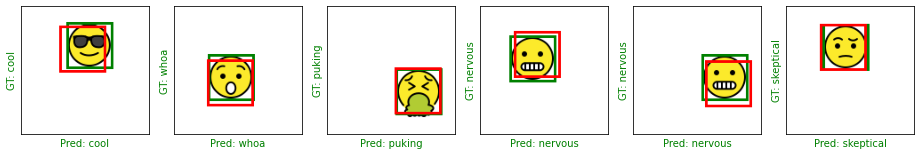

500/500 [==============================] - 15s 31ms/step - loss: 0.0017 - class_out_loss: 3.2737e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.7395
Epoch 22/50
499/500 [============================>.] - ETA: 0s - loss: 0.0017 - class_out_loss: 3.3564e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.7413

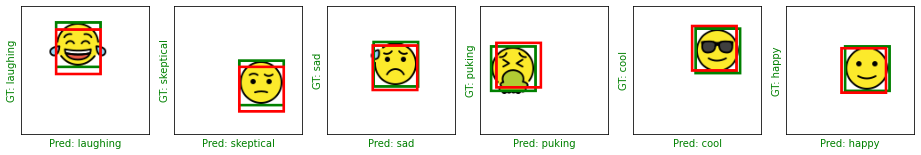

500/500 [==============================] - 16s 31ms/step - loss: 0.0017 - class_out_loss: 3.3519e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.7413
Epoch 23/50
500/500 [==============================] - ETA: 0s - loss: 0.0017 - class_out_loss: 3.4415e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.7400

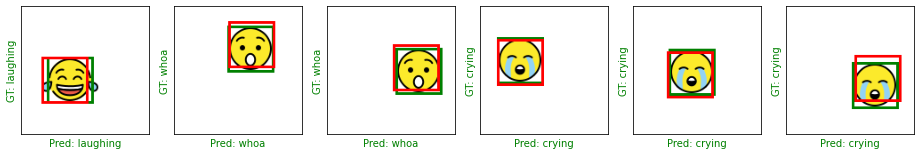

500/500 [==============================] - 16s 31ms/step - loss: 0.0017 - class_out_loss: 3.4415e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.7400
Epoch 24/50
500/500 [==============================] - ETA: 0s - loss: 0.0018 - class_out_loss: 3.8390e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.7399

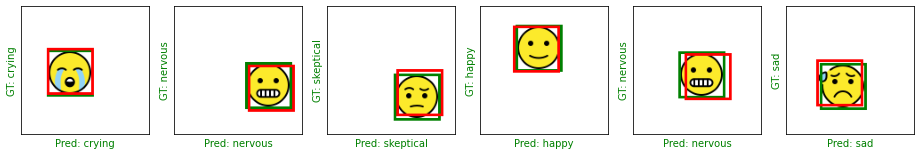

500/500 [==============================] - 16s 31ms/step - loss: 0.0018 - class_out_loss: 3.8390e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.7399
Epoch 25/50
499/500 [============================>.] - ETA: 0s - loss: 0.0017 - class_out_loss: 3.4349e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.7420

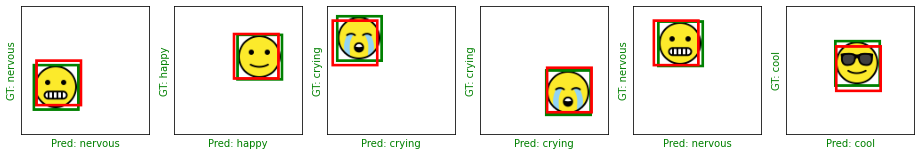

500/500 [==============================] - 16s 32ms/step - loss: 0.0017 - class_out_loss: 3.4386e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.7420
Epoch 26/50
499/500 [============================>.] - ETA: 0s - loss: 0.0017 - class_out_loss: 3.2348e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7429

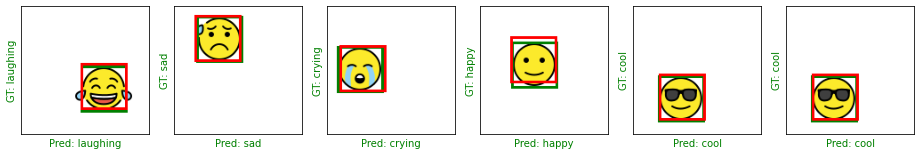

500/500 [==============================] - 16s 32ms/step - loss: 0.0017 - class_out_loss: 3.2292e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7430
Epoch 27/50
500/500 [==============================] - ETA: 0s - loss: 0.0017 - class_out_loss: 3.4934e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.7406

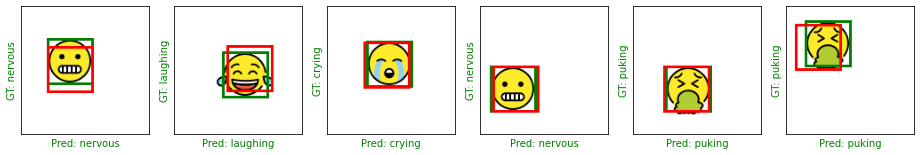

500/500 [==============================] - 16s 33ms/step - loss: 0.0017 - class_out_loss: 3.4934e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.7406
Epoch 28/50
500/500 [==============================] - ETA: 0s - loss: 0.0016 - class_out_loss: 3.0413e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7444

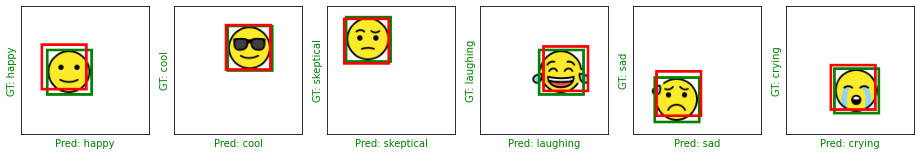

500/500 [==============================] - 16s 32ms/step - loss: 0.0016 - class_out_loss: 3.0413e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7444
Epoch 29/50
499/500 [============================>.] - ETA: 0s - loss: 0.0017 - class_out_loss: 3.4397e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7454

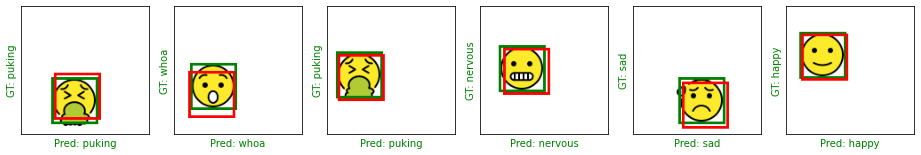

500/500 [==============================] - 16s 33ms/step - loss: 0.0017 - class_out_loss: 3.4375e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7453
Epoch 30/50
500/500 [==============================] - ETA: 0s - loss: 0.0016 - class_out_loss: 3.2994e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7447

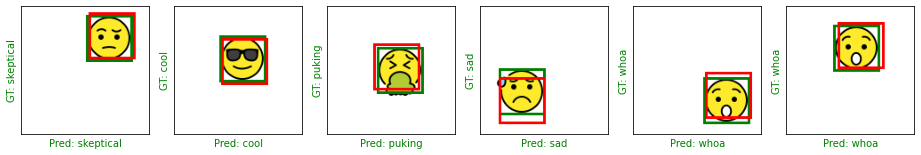

500/500 [==============================] - 16s 32ms/step - loss: 0.0016 - class_out_loss: 3.2994e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7447
Epoch 31/50
500/500 [==============================] - ETA: 0s - loss: 0.0016 - class_out_loss: 2.9387e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7439

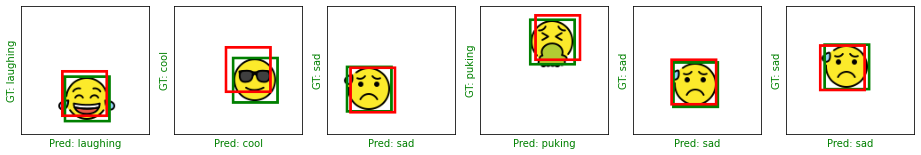

500/500 [==============================] - 16s 33ms/step - loss: 0.0016 - class_out_loss: 2.9387e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7439
Epoch 32/50
499/500 [============================>.] - ETA: 0s - loss: 0.0017 - class_out_loss: 3.5428e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7462

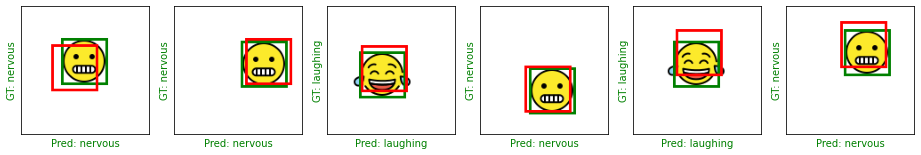

500/500 [==============================] - 16s 33ms/step - loss: 0.0017 - class_out_loss: 3.5378e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7462
Epoch 33/50
500/500 [==============================] - ETA: 0s - loss: 0.0017 - class_out_loss: 3.7342e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7442

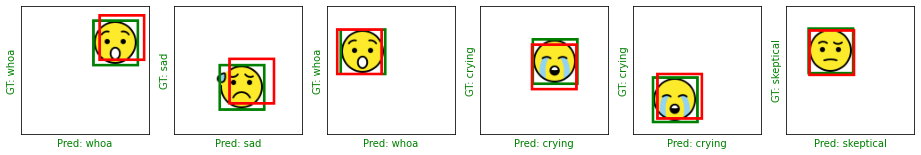

500/500 [==============================] - 16s 33ms/step - loss: 0.0017 - class_out_loss: 3.7342e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7442
Epoch 34/50
500/500 [==============================] - ETA: 0s - loss: 0.0017 - class_out_loss: 3.1383e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7419

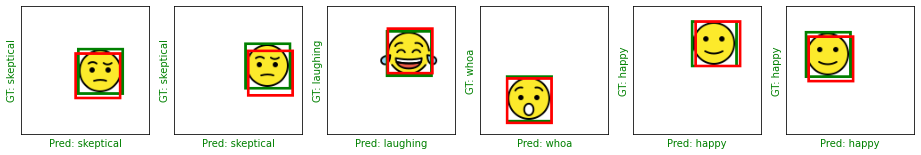

500/500 [==============================] - 17s 34ms/step - loss: 0.0017 - class_out_loss: 3.1383e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7419
Epoch 35/50
500/500 [==============================] - ETA: 0s - loss: 0.0016 - class_out_loss: 3.0631e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7465

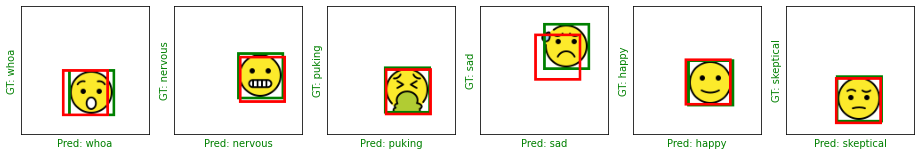

500/500 [==============================] - 17s 33ms/step - loss: 0.0016 - class_out_loss: 3.0631e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7465
Epoch 36/50
500/500 [==============================] - ETA: 0s - loss: 0.0017 - class_out_loss: 3.4053e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7441

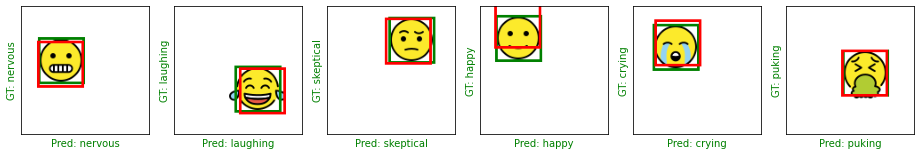

500/500 [==============================] - 17s 34ms/step - loss: 0.0017 - class_out_loss: 3.4053e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7441
Epoch 37/50
500/500 [==============================] - ETA: 0s - loss: 0.0017 - class_out_loss: 3.7419e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.7402

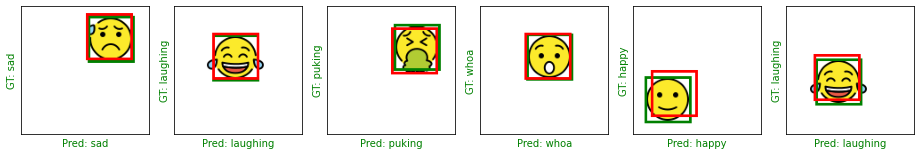

500/500 [==============================] - 17s 34ms/step - loss: 0.0017 - class_out_loss: 3.7419e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.7402
Epoch 38/50
499/500 [============================>.] - ETA: 0s - loss: 0.0017 - class_out_loss: 3.6391e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7455

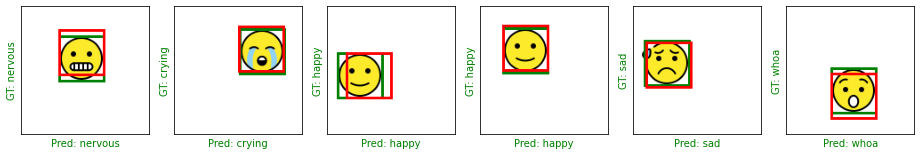

500/500 [==============================] - 17s 34ms/step - loss: 0.0017 - class_out_loss: 3.6389e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7456


In [ ]:
def lr_schedule(epoch, lr):
    if (epoch + 1) % 5 == 0:
        lr *= 0.2
    return max(lr, 3e-7)

_ = model.fit(
    data_generator(), 
    epochs = 50,
    steps_per_epoch = 500, 
    callbacks = [
                 ShowTestImages(), 
                 tf.keras.callbacks.EarlyStopping(monitor='box_out_iou', patience = 3, mode = 'max'),
                 tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)